In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
lr = 0.001
batch_size = 100
n_epochs = 100

embedding_dim = 3
lstm_hidden_size = 5
lstm_num_layers = 1

In [3]:
df = pd.read_csv(
    "../data/SpamClassification/preprocessed_spam.csv",
    sep=",",
    header=0,
    index_col=0,
)

df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
from sklearn.model_selection import train_test_split

dataset = df.to_numpy()

X = dataset[:, 0]
Y = dataset[:, 1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, random_state=42)

In [5]:
text_iter = iter(X_train)

tokenizer = get_tokenizer("basic_english")


def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(text_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])


In [6]:
def add_padding(arr, max_len):

  zeros = np.ones(0)
  if len(arr) < max_len:
    zeros = np.zeros(max_len - len(arr))
  arr = np.concatenate((zeros, arr))

  return arr

In [7]:
max_len = np.max([len(tokenizer(x)) for x in X])
print(max_len)

text_pipeline = np.vectorize(lambda x: add_padding(vocab(tokenizer(x)), max_len))

212


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device {device} is being used')

Device cuda is being used


In [9]:
train_inputs = torch.from_numpy(np.array(list(map(text_pipeline, X_train)))).type(torch.LongTensor).to(device)
train_targets = torch.from_numpy(Y_train.astype(np.longlong)).type(torch.LongTensor).to(device)
test_inputs = torch.from_numpy(np.array(list(map(text_pipeline, X_test)))).type(torch.LongTensor).to(device)
test_targets = torch.from_numpy(Y_test.astype(np.longlong)).type(torch.LongTensor).to(device)

print(train_inputs.shape)
print(train_targets.shape)
print(test_inputs.shape)
print(test_targets.shape)

torch.Size([2786, 212])
torch.Size([2786])
torch.Size([2786, 212])
torch.Size([2786])


In [10]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [11]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        output_size,
    ):
        super(CNN, self).__init__()
        self.embed = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
        )
        self.conv1 = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        self.conv2 = nn.Conv1d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.conv3 = nn.Conv1d(
            in_channels=64,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.fc = nn.Linear(128, output_size)

    def forward(self, inputs):
        outputs = self.embed(outputs)
        outputs = torch.permute(outputs, (0, 2, 1))
        
        outputs = self.conv1(inputs)
        outputs = F.relu(outputs)
        outputs = F.max_pool1d(outputs, 2)
        outputs = self.conv2(inputs)
        outputs = F.relu(outputs)
        outputs = F.max_pool1d(outputs, 2)
        outputs = self.conv3(inputs)
        outputs = F.relu(outputs)
        outputs = F.max_pool1d(outputs, 2)
        
        outputs = torch.permute(outputs, (0, 2, 1))
        outputs, _ = torch.max(outputs, dim=1)
        
        outputs = self.fc(outputs)

        return outputs


In [12]:
model = CNN(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    output_size=2,
)

model.to(device)

RNN(
  (emb): Embedding(6403, 3)
  (rnn): LSTM(3, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=2, bias=True)
)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [14]:
def validate(dataset, batch_size=128):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
    )

    tot_predicted = 0
    tot_correct = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        tot_predicted += inputs.shape[0]
        outputs = model(inputs)

        _, predictions = torch.max(outputs, dim=1)

        tot_correct += (predictions == targets).sum()

    return (tot_correct/tot_predicted)

In [15]:
def train(n_epochs=100):

    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    train_accuracies = np.zeros(n_epochs)
    test_accuracies = np.zeros(n_epochs)

    for it in range(n_epochs):

        train_loss = []
        test_loss = []

        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_losses[it] = np.mean(train_loss)

        for i, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_losses[it] = np.mean(test_loss)

        train_accuracies[it] = validate(train_dataset, batch_size=batch_size)
        test_accuracies[it] = validate(test_dataset, batch_size=batch_size)

        print(
            f"Iteration: {it+1:4.0f}/{n_epochs}\tTrain Loss: {train_losses[it]:.6f}\tTest Loss: {test_losses[it]:.6f}\tTrain Accuracy: {train_accuracies[it]:.6f}\tTest Accuracy: {test_accuracies[it]:.6f}"
        )

    return train_losses, test_losses, train_accuracies, test_accuracies


In [16]:
train_losses, test_losses, train_accuracies, test_accuracies = train(n_epochs=n_epochs)


Iteration:    1/100	Train Loss: 0.779348	Test Loss: 0.734350	Train Accuracy: 0.134243	Test Accuracy: 0.136037
Iteration:    2/100	Train Loss: 0.688318	Test Loss: 0.637337	Train Accuracy: 0.866116	Test Accuracy: 0.865398
Iteration:    3/100	Train Loss: 0.587803	Test Loss: 0.538278	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:    4/100	Train Loss: 0.497227	Test Loss: 0.461625	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:    5/100	Train Loss: 0.437276	Test Loss: 0.418756	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:    6/100	Train Loss: 0.407935	Test Loss: 0.399059	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:    7/100	Train Loss: 0.394121	Test Loss: 0.391058	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:    8/100	Train Loss: 0.388731	Test Loss: 0.387012	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:    9/100	Train Loss: 0.385109	Test Loss: 0.384771	Train Accuracy: 0.866475	Test Accuracy: 0.865398
Iteration:

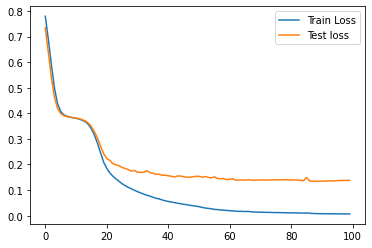

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

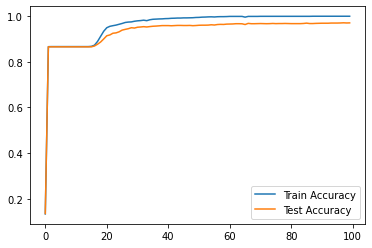

In [18]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()